In [271]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
from sklearn import datasets
import pandas as pd
import tensorflow as tf
from tensorflow import keras

spotify_data = pd.read_csv("./spotify_tracks.csv",encoding='latin-1')
spotify_data['album.release_date'] = spotify_data['album.release_date'].str.split('-').str[0]
spotify_data = spotify_data.drop(columns=['Unnamed: 0', 'disc_number','href','name'])
spotify_data= spotify_data.rename(columns={"duration_ms.x": "duration", "album.release_date": "album release date"})
spotify_data = spotify_data.astype({"album release date": int})
spotify_data["duration"] /= 1000
spotify_data["loudness"] -= spotify_data["loudness"].min()

spotify_sample = spotify_data[(2018 <= spotify_data['album release date'])]
#spotify_sample = spotify_data[(2020 > spotify_data['album release date']) & (spotify_data['album release date'] >= 2016)]

spotify_sample.loc[spotify_sample['popularity']<50, 'rating'] = 1
spotify_sample.loc[(spotify_sample['popularity']>=50) & (spotify_sample['popularity']< 90), 'rating'] = 2
spotify_sample.loc[(spotify_sample['popularity']>= 90) & (spotify_sample['popularity']<=100), 'rating'] = 3


spotify_sample = spotify_sample[['speechiness','danceability',
                                 'energy', 'loudness','acousticness',
                                 'instrumentalness','rating']]


spotify_sample.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,speechiness,danceability,energy,loudness,acousticness,instrumentalness,rating
1,0.0344,0.573,0.846,49.510,0.00372,0.000079,2.0
3,0.1380,0.842,0.578,48.326,0.00419,0.000000,2.0
5,0.0297,0.684,0.564,47.524,0.42500,0.000000,2.0
6,0.0416,0.675,0.915,47.677,0.03290,0.210000,2.0
7,0.0381,0.387,0.326,45.334,0.98100,0.953000,1.0


In [272]:
sp_df_popularity_count = pd.DataFrame(spotify_sample.groupby('rating')['rating'].count())
sp_df_popularity_count.tail(30)

,rating
rating,
1.0,2751
2.0,7079
3.0,40


In [273]:
# structure data for model
from sklearn.preprocessing import StandardScaler
spotify_sample

X = spotify_sample.iloc[:,:-1].values
y = spotify_sample["rating"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train and test split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [187]:
y_test

array([1., 1., 2., ..., 1., 0., 1.])

In [274]:

from sklearn.model_selection import cross_val_score, KFold


X_train_scaled = X_train

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(50, input_dim = 6, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(500, activation = 'relu'))
#model.add(Dense(50, activation = 'relu'))
model.add(Dense(1,kernel_initializer = 'normal'))
optimizer = tf.keras.optimizers.RMSprop(0.1)
model.compile(loss= 'mse', optimizer= optimizer, metrics = ['mae','mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(X_train_scaled, y_train, verbose = 2, epochs = EPOCHS, batch_size = 10, validation_split = 0.1,callbacks=[early_stop, PrintDot()])
#hist = pd.DataFrame(history.history)

Train on 7106 samples, validate on 790 samples
Epoch 1/1000
 - 1s - loss: 746.0385 - mae: 1.3106 - mse: 746.0378 - val_loss: 0.1690 - val_mae: 0.2837 - val_mse: 0.1690

.Epoch 2/1000
 - 1s - loss: 0.1786 - mae: 0.3174 - mse: 0.1786 - val_loss: 0.1736 - val_mae: 0.2813 - val_mse: 0.1736
.Epoch 3/1000
 - 1s - loss: 0.2113 - mae: 0.3144 - mse: 0.2113 - val_loss: 0.2685 - val_mae: 0.2783 - val_mse: 0.2685
.Epoch 4/1000
 - 1s - loss: 0.1802 - mae: 0.3095 - mse: 0.1802 - val_loss: 0.2376 - val_mae: 0.2671 - val_mse: 0.2376
.Epoch 5/1000
 - 1s - loss: 0.2517 - mae: 0.3258 - mse: 0.2517 - val_loss: 0.1682 - val_mae: 0.3076 - val_mse: 0.1682
.Epoch 6/1000
 - 1s - loss: 0.1837 - mae: 0.3172 - mse: 0.1837 - val_loss: 0.1758 - val_mae: 0.3813 - val_mse: 0.1758
.Epoch 7/1000
 - 1s - loss: 0.1765 - mae: 0.3122 - mse: 0.1765 - val_loss: 0.1770 - val_mae: 0.3666 - val_mse: 0.1770
.Epoch 8/1000
 - 1s - loss: 0.1698 - mae: 0.3051 - mse: 0.1698 - val_loss: 0.1777 - val_mae: 0.3893 - val_mse: 0.1777
.Epoc

In [275]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
22,0.177915,0.324313,0.177915,0.167879,0.306764,0.167879,22
23,0.232742,0.295088,0.232742,0.168904,0.307180,0.168904,23
24,0.169076,0.353010,0.169076,0.166792,0.304495,0.166792,24
25,0.169051,0.286753,0.169051,0.165901,0.304912,0.165901,25
26,0.167752,0.301080,0.167752,0.167470,0.304654,0.167470,26


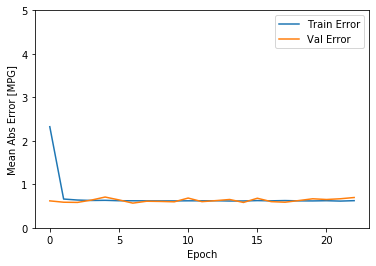

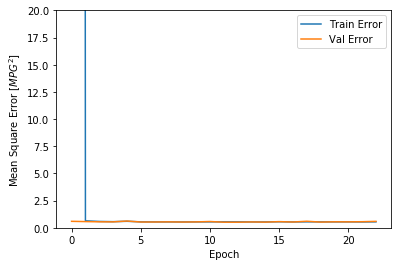

In [265]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [69]:
hist

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.215678,0.333708,0.215678,904.206886,1.491896,904.206604,0
1,0.247207,0.298075,0.247207,0.231717,0.341787,0.231717,1
2,0.226230,0.394873,0.226230,0.228107,0.335476,0.228107,2
3,0.216189,0.345738,0.216189,0.225558,0.332729,0.225557,3
4,0.230480,0.328964,0.230480,0.224725,0.334940,0.224725,4
5,0.220387,0.316110,0.220387,0.223329,0.332767,0.223329,5
6,0.220383,0.351302,0.220383,0.226440,0.327400,0.226440,6
7,0.234471,0.323778,0.234471,0.225557,0.329987,0.225557,7
8,0.211270,0.333776,0.211270,0.220754,0.325456,0.220754,8
9,0.217341,0.299485,0.217340,0.217755,0.322217,0.217755,9


In [282]:
test_predictions = model.predict(X_test)


len(test_predictions)

In [281]:
score = 0
for i in range(len(test_predictions)):
    test_num = round(test_predictions[i][0])
    if test_num == y_test[i]:
        score += 1
        
    #print(test_num,y_test[i])
print(score/len(test_predictions)*100)
    

80.3951367781155
